# Apply k-NN on Amazon reviews data-set

In [1]:
# importing library
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\DVS0283\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
#creating new datasets after applying filter on reviews dataset

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
# with the help of this method returning positive and negative based on the score

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
print(filtered_data.shape) #looking at the size of the data
filtered_data.head() # top five reviews, just for understanding 

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# delete the reviews which is same on the basis of few features 
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape # after deleting, look at shape again

(364173, 10)

In [5]:
final.head() # look at top five reviews 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# As we know that helfulnessnumerator will not  be greater than helpfullness denominator 
# So we will remove that reviews because that reviews no make sense 

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
# after removing reviews in above cell which were useless, no make sense
# so look at the reviewsprint(final.shape)
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text Preprocessing

In [8]:
# Removing Stop-words

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence):  #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):  #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): # assure that cleaned words are alphabetical and length is greater than 2
                if(cleaned_words.lower() not in stop):  # thos words who were not in stop words
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') # changing cleaned words into lower case
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':  #IF words are positive 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative': # if words are negative
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1) #final_string dataset appending string after cleaning words
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [11]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


In [12]:
final.shape # look at the shape of final dataset 

(364171, 11)

In [13]:
# we are taking random sample of 40000 reviews 
final=final.sample(40000)
final.shape

(40000, 11)

In [14]:
# sorting data on the basis of time stamp for time based splitting 
sorted_data=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data

In [15]:
# importing library for k-nn algorithm
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation



C:\Users\DVS0283\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Applying knn

In [16]:
# first of all we wil split the data 
# in train and test data

In [17]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['CleanedText'].values, final['Score'], test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


# KNN on Bag Of Words

In [18]:
# we are collecting all the split words in the form of tokens matrix
count_vect = CountVectorizer() #in scikit-learn
X_train_bow = count_vect.fit_transform(X_tr) #giving training data set to vectorize the training data
X_tes = count_vect.transform(X_test) #giving testing data set to vectorize the testing data
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19600, 17668)
the number of unique words  17668


# 10 fold cross validation (brute force)


The optimal number of neighbors is 13.


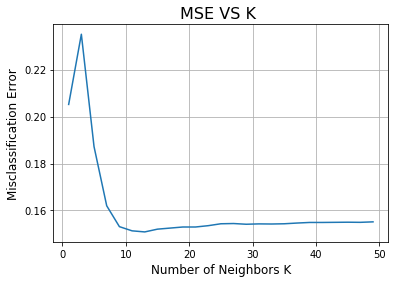

the misclassification error for each k value is :  [0.205 0.235 0.187 0.162 0.153 0.151 0.151 0.152 0.152 0.153 0.153 0.154
 0.154 0.154 0.154 0.154 0.154 0.154 0.155 0.155 0.155 0.155 0.155 0.155
 0.155]


In [19]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList)) # anonymous function lambda which returns only odd value in the form of list

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors: #loop for all the odd value of k with te help of neighbours
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute') # Classifier implementing the k-nearest neighbors vote
    
    scores = cross_val_score(knn, X_train_bow,y_tr, cv=10, scoring='accuracy') #Evaluate a score by cross-validation
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)


plt.xlabel('Number of Neighbors K',size=12)
plt.ylabel('Misclassification Error',size=12)
plt.title('MSE VS K ',size=16)
plt.grid()
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# optimal k with brute force

In [20]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train_bow, y_tr)

# predict the response
pred = knn_optimal.predict(X_tes)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 13 is 85.016667%


# Confusion matrix

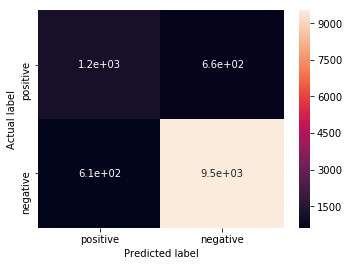

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

clf = SVC(kernel = 'linear').fit(X_train_bow,y_tr)
clf.predict(X_train_bow)
y_pred = clf.predict(X_tes)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# 10 fold cross validation (kd tree)

In [22]:
#Dimensionality reduction using truncated SVD 
# as we know that bow vectorizer return sparse matrix 
# with sparse matric we can not use kd tree algorithm 
# and if we convert sparse in to dense matric then kd tree gives memory error
# then we used truncatedsvd to take top important 100 features to use kd tree algorithmm


from sklearn.decomposition import TruncatedSVD #importing library
svd = TruncatedSVD(n_components=100) # taking top 100 most important features
X_train_bow_kd=svd.fit_transform(X_train_bow) #then we fit the model with X_train data of bow
X_test_kd=svd.transform(X_tes) # perform dimensionality reduction on X.


The optimal number of neighbors is 23.


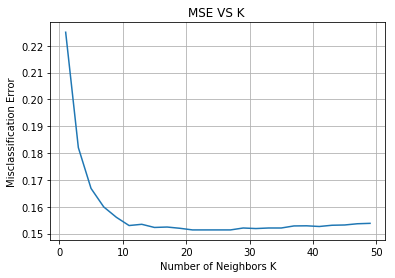

the misclassification error for each k value is :  [0.225 0.182 0.167 0.16  0.156 0.153 0.153 0.152 0.152 0.152 0.151 0.151
 0.151 0.151 0.152 0.152 0.152 0.152 0.153 0.153 0.153 0.153 0.153 0.154
 0.154]


In [23]:
# TO HIDE WARNINGS importing library
import warnings
warnings.filterwarnings('ignore')

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree') # Classifier implementing the k-nearest neighbors vote
    scores = cross_val_score(knn, X_train_bow_kd , y_tr, cv=10, scoring='accuracy') #Evaluate a score by cross-validation
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
# plot misclassification error vs k 
plt.plot(neighbors, MSE)


plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.title('MSE VS K ')
plt.grid()
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# optimal k with kd tree

In [24]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train_bow_kd, y_tr)

# predict the response
pred = knn_optimal.predict(X_test_kd)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 23 is 84.908333%


# KNN on TF-IDF

In [25]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['CleanedText'].values, final['Score'], test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
X_train_tfidf = tf_idf_vect.fit_transform(X_tr)

# 10 fold cross validation (brute force)


The optimal number of neighbors is 13.


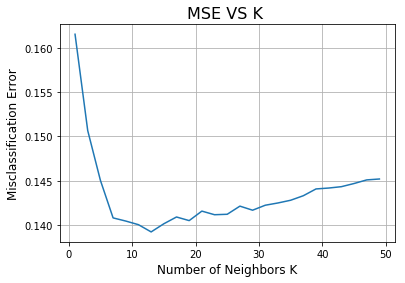

the misclassification error for each k value is :  [0.162 0.151 0.145 0.141 0.14  0.14  0.139 0.14  0.141 0.141 0.142 0.141
 0.141 0.142 0.142 0.142 0.142 0.143 0.143 0.144 0.144 0.144 0.145 0.145
 0.145]


In [27]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute') # Classifier implementing the k-nearest neighbors vote
    scores = cross_val_score(knn, X_train_tfidf,y_tr, cv=10, scoring='accuracy') #Evaluate a score by cross-validation
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)


plt.xlabel('Number of Neighbors K',size=12)
plt.ylabel('Misclassification Error',size=12)
plt.title('MSE VS K ',size=16)
plt.grid()
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))


# optimal k on brute force

In [28]:
X_test_tfidf = tf_idf_vect.transform(X_test)

In [29]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train_tfidf, y_tr)

# predict the response
pred = knn_optimal.predict(X_test_tfidf)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 13 is 86.083333%


# Confusion matix

In [30]:
clf = SVC(kernel = 'linear').fit(X_train_tfidf,y_tr)
clf.predict(X_train_tfidf)

array(['positive', 'positive', 'negative', ..., 'positive', 'positive',
       'positive'], dtype=object)

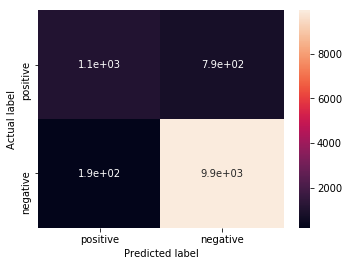

In [31]:
y_pred = clf.predict(X_test_tfidf)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# 10 fold cross validation (kd tree)

In [32]:
#Dimensionality reduction using truncated SVD 
# as we know that bow vectorizer return sparse matrix 
# with sparse matric we can not use kd tree algorithm 
# and if we convert sparse in to dense matric then kd tree gives memory error
# then we used truncatedsvd to take top important 100 features to use kd tree algorithmm

X_train_tfidf_kd=svd.fit_transform(X_train_tfidf)#then we fit the model with X_train data of tfidf
X_test_tfidf_kd=svd.transform(X_test_tfidf) # perform dimensionality reduction on X.


The optimal number of neighbors is 25.


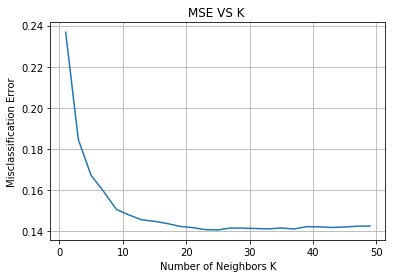

the misclassification error for each k value is :  [0.237 0.185 0.167 0.159 0.151 0.148 0.146 0.145 0.144 0.142 0.142 0.141
 0.141 0.142 0.142 0.141 0.141 0.142 0.141 0.142 0.142 0.142 0.142 0.143
 0.143]


In [33]:

import warnings
warnings.filterwarnings('ignore')
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn,X_train_tfidf_kd, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)


plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.title('MSE VS K ')
plt.grid()
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# optimal k on kd tree 

In [34]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train_tfidf_kd, y_tr)

# predict the response
pred = knn_optimal.predict(X_test_tfidf_kd)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 25 is 86.233333%


# KNN On AvgW2V

In [35]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['CleanedText'].values, final['Score'], test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

In [36]:
#for train data we are finding avg w2v for each train data
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_tr:
    list_of_sent.append(sent.split())

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [37]:
X_train_avgw2v = []; # the X_train_avgw2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)

In [38]:
#for test data we are finding avg w2v for each test data
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [39]:
X_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)

# 10 fold cross validation (brute force)


The optimal number of neighbors is 15.


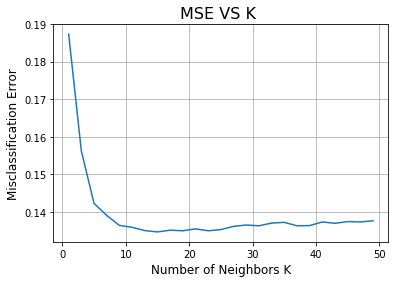

the misclassification error for each k value is :  [0.187 0.156 0.142 0.139 0.136 0.136 0.135 0.135 0.135 0.135 0.135 0.135
 0.135 0.136 0.136 0.136 0.137 0.137 0.136 0.136 0.137 0.137 0.137 0.137
 0.138]


In [40]:


# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn,X_train_avgw2v ,y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)


plt.xlabel('Number of Neighbors K',size=12)
plt.ylabel('Misclassification Error',size=12)
plt.title('MSE VS K ',size=16)
plt.grid()
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))


# optimal k on brute force

In [41]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train_avgw2v, y_tr)

# predict the response
pred = knn_optimal.predict(X_test_avgw2v)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 15 is 85.450000%


# Confusion matrix

In [42]:
clf = SVC(kernel = 'linear').fit(X_train_avgw2v,y_tr)
clf.predict(X_train_avgw2v)


array(['negative', 'positive', 'positive', ..., 'positive', 'positive',
       'positive'], dtype=object)

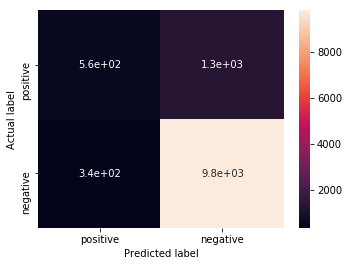

In [43]:
y_pred = clf.predict(X_test_avgw2v)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# 10 fold cross validation (kd tree)


The optimal number of neighbors is 15.


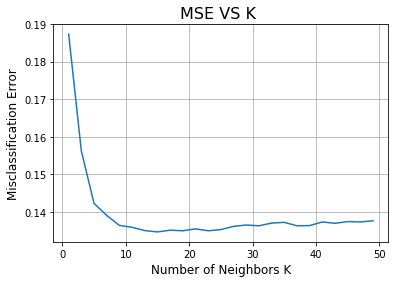

the misclassification error for each k value is :  [0.187 0.156 0.142 0.139 0.136 0.136 0.135 0.135 0.135 0.135 0.135 0.135
 0.135 0.136 0.136 0.136 0.137 0.137 0.136 0.136 0.137 0.137 0.137 0.137
 0.138]


In [44]:

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_avgw2v, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)


plt.xlabel('Number of Neighbors K',size=12)
plt.ylabel('Misclassification Error',size=12)
plt.title('MSE VS K ',size=16)
plt.grid()
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# optimal k on kd tree

In [45]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train_avgw2v, y_tr)

# predict the response
pred = knn_optimal.predict(X_test_avgw2v)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 15 is 85.450000%


# KNN On TF-IDF W2V

In [46]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['CleanedText'].values, final['Score'], test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


In [47]:
#for train data 
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_tr)

In [48]:
# Train your own tfidf Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_tr:
    list_of_sent.append(sent.split())

In [49]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    row += 1

In [50]:
# for test data
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_test)

In [51]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())

In [52]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_test_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    row += 1

# 10 fold cross validation (brute force)


The optimal number of neighbors is 17.


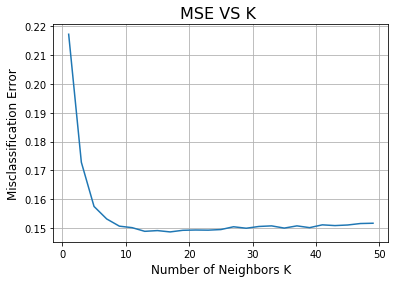

the misclassification error for each k value is :  [0.217 0.173 0.158 0.153 0.151 0.15  0.149 0.149 0.149 0.149 0.149 0.149
 0.149 0.15  0.15  0.151 0.151 0.15  0.151 0.15  0.151 0.151 0.151 0.152
 0.152]


In [53]:

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_tfidfw2v,y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)


plt.xlabel('Number of Neighbors K',size=12)
plt.ylabel('Misclassification Error',size=12)
plt.title('MSE VS K ',size=16)
plt.grid()
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))


# optimal k on brute force

In [54]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train_tfidfw2v, y_tr)

# predict the response
pred = knn_optimal.predict(X_test_tfidfw2v)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 85.683333%


# Confusion matrix

In [55]:
clf = SVC(kernel = 'linear').fit(X_train_tfidfw2v,y_tr)
clf.predict(X_train_tfidfw2v)

array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'positive'], dtype=object)

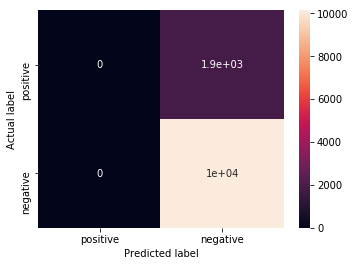

In [56]:
y_pred = clf.predict(X_test_tfidfw2v)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# 10 fold cross validation (kd tree)


The optimal number of neighbors is 17.


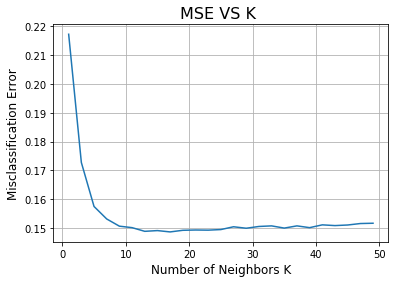

the misclassification error for each k value is :  [0.217 0.173 0.158 0.153 0.151 0.15  0.149 0.149 0.149 0.149 0.149 0.149
 0.149 0.15  0.15  0.151 0.151 0.15  0.151 0.15  0.151 0.151 0.151 0.152
 0.152]


In [57]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_tfidfw2v, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)


plt.xlabel('Number of Neighbors K',size=12)
plt.ylabel('Misclassification Error',size=12)
plt.title('MSE VS K ',size=16)
plt.grid()
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# optimal k on kd tree 

In [58]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train_tfidfw2v, y_tr)

# predict the response
pred = knn_optimal.predict(X_test_tfidfw2v)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 85.683333%


In [6]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Optimal k", "Train error", "Test error"]

x.add_row(["Brute force(BOW)", 13, 0.151, 15])
x.add_row(["Kd tree(BOW)", 23, 0.151, 15.10])
x.add_row(["Brute force(tfidf)", 13, 0.141, 14])
x.add_row(["Kd tree(tfidf)", 25, 0.141, 13.77])
x.add_row(["Brute force(avgw2v)", 15, 0.135, 14.55])
x.add_row(["Kd tree(avgw2v)", 15, 0.135, 14.55])
x.add_row(["Brute force(tfidfw2v)", 17, 0.149, 14.32])
x.add_row(["Kd tree(tfidfw2v)", 17, 0.149, 14.32])

print(x)

+-----------------------+-----------+-------------+------------+
|         Model         | Optimal k | Train error | Test error |
+-----------------------+-----------+-------------+------------+
|    Brute force(BOW)   |     13    |    0.151    |     15     |
|      Kd tree(BOW)     |     23    |    0.151    |    15.1    |
|   Brute force(tfidf)  |     13    |    0.141    |     14     |
|     Kd tree(tfidf)    |     25    |    0.141    |   13.77    |
|  Brute force(avgw2v)  |     15    |    0.135    |   14.55    |
|    Kd tree(avgw2v)    |     15    |    0.135    |   14.55    |
| Brute force(tfidfw2v) |     17    |    0.149    |   14.32    |
|   Kd tree(tfidfw2v)   |     17    |    0.149    |   14.32    |
+-----------------------+-----------+-------------+------------+


# Conclusion

1. In this assignment i have applied knn on amazon reviews dataset which is real dataset of amazon food reviews.
2. We have to apply knn so brief introduction of knn. knn is classifying algorithm it classify the class label with the help of training data points if any new data points come then it claculate the distance with the help of optimal k then it counts the majority vote of data points. then we check the majority data points belongs to which class label. then we assigned that new data points to that majority points.
2. First of all, we talk about the procedure of applying knn on amazon fine food reviews dataset, at first i read the reviews dataset as usual then i cleaned the data, after cleaning data i did the data preprocessing which contains removing html tags, rmoving punctuation and removing special characters . it was all part of the data preprocessing.
3. After data preprocessing, i split the cleaned data with the help of train test and split method in python, then i develop bag of words of training data and also test data because as we have to apply brute force with the help of 10 fold cross validation, and we got sparse matrix after develop baf of words then i applied brute force on train data to train the model after that we find the optimal k with the brute force algorithm and also find the test accuracy of brute force algorithm
4. Still we have done brute force algorithm with the help of 10 fold cross validation then i done kd tree algorithm with the help of 10 fold cross validation. If we apply kd tree algorithm then we need dense matrix instead of sparse matrix for changing the sparse matrix into dense matrix i reduce the dimensions of train data with the help of truncated svd as mentioned in this assignment already, then i test the kd tree algorithm accuracy and also we find the optimal k 
5. Aftr apllying both the brute force algorithm and kd tree algorithm with the help of 10 fold cross validation we did the same procedure for tf-idf then we did the average w2v and tf-idf w2v. and in this both the average w2v and tf-idf w2v there is no need to reduce the dimensions of reviews dataset because it gives output already in the form of dense matrix 
6. So we applied brute force algorithm and kd tree algorithm with the help 10 fold cross validation on bag of words, tf-idf, average w2v and tf-idf w2v to find the optimal k and accuracy of both the algorithm .